# Brain Tumor Detection with Syft & SyMPC
Oleksandr Lytvyn
dataset link: [kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection)

## Data Scientist
#### TASKS
1. Create model
2. Train model on sample data
3. Create request to access encrypted data from DOs
4. Make prediction on encrypted data
5. Share prediction with corresponding DOs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from PIL import Image
import syft as sy
import os

from notebooks.transformed_dataset import TransformedImageDataset

device = torch.device('cpu')
torch.manual_seed(1)

In [2]:
dir_path = '../../data/prepared_brain_tumor_imgs/ds'
ds_test_data = TransformedImageDataset(images_path=dir_path + '/test/imgs',
                                       labels_path=dir_path + '/test/labels')
ds_train_data = TransformedImageDataset(images_path=dir_path + '/train/imgs',
                                        labels_path=dir_path + '/train/labels')

print(f"test dataset {len(ds_test_data)}")
print(f"train dataset {len(ds_train_data)}")

test dataset 84
train dataset 1013


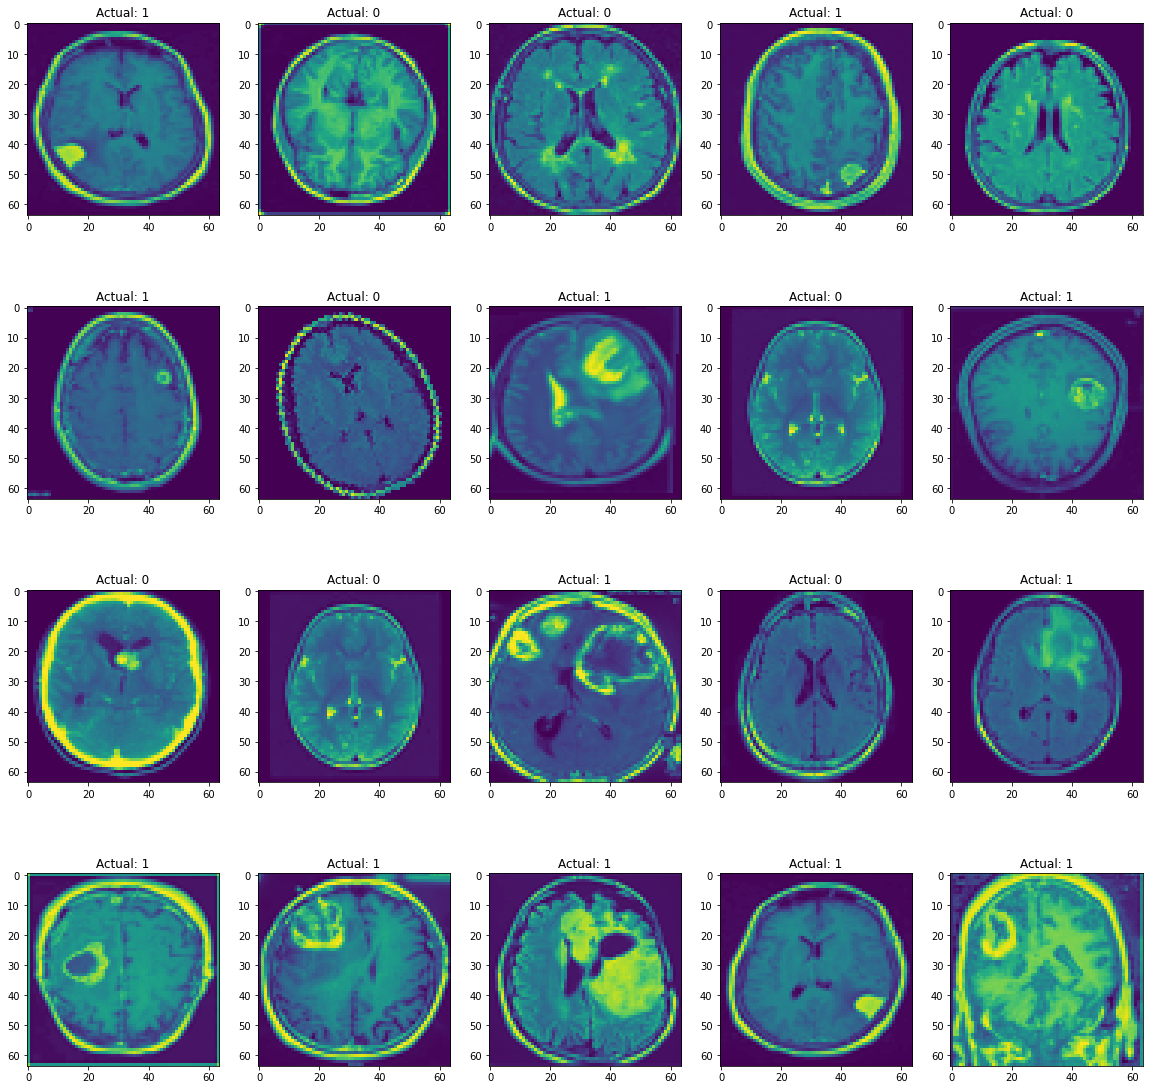

In [4]:
fig = plt.figure(figsize=(20,20))
for i in range(20):
    target = ds_test_data[i][1]
    plt.subplot(4,5, i+1)
    plt.imshow(transforms.ToPILImage()(ds_test_data[i][0]))
    plt.title(f'Actual: {target}')
plt.show()

In [3]:
class BrainTumorModel(sy.Module):
    def __init__(self, torch_ref):
        super(BrainTumorModel, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = self.torch_ref.nn.Conv2d(128,32,kernel_size=2)
        self.linear1 = self.torch_ref.nn.Linear(30,64)
        self.linear2 = self.torch_ref.nn.Linear(64,32)
        self.flat = self.torch_ref.nn.Flatten(1)
        self.linear3 = self.torch_ref.nn.Linear(30720,2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.torch_ref.nn.functional.max_pool2d(x,2)
        x = self.conv2(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.linear1(x)
        x = self.torch_ref.nn.functional.relu(x)
        x = self.linear2(x)
        x = self.flat(x)
        x = self.linear3(x)
        return x
model = BrainTumorModel(torch_ref=torch)
print(model)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 500

In [9]:
def test(model, test_loader, loss_fn):
    test_loss = 0
    accuracy = 0
    number_of_imags = len(test_loader)
    for image, label in test_loader:
        pred = model.forward(image.float())
        test_loss += loss_fn(pred, label).item()
        pred = torch.argmax(pred, dim=1)

        equality = (label.data == pred)
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss/number_of_imags, accuracy/number_of_imags

def train(model, train_data, test_data, num_epochs = 100, batch_size = 32):
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        i=0
        for batch in train_loader:
            optimizer.zero_grad()
            image, label = batch
            images_batch = Variable(image)
            labels_batch = Variable(label)
            output = model(images_batch.float())
            loss = loss_fn(output, labels_batch)
            total_loss += loss
            loss.backward()
            optimizer.step()
            i+=1
            break
        if epoch%10 == 0:
            test_loss, accuracy = test(model, test_loader, loss_fn)
            print(f'Epochs: {epoch} Loss: {total_loss/i: .4f}, Accuracy: {accuracy: .4f}')
        #             print('-----------------------------------------------')
        loss_list.append(total_loss/batch_size)
    return loss_list

Epochs: 0 Loss:  0.6888, Accuracy:  0.6375
Epochs: 10 Loss:  0.6857, Accuracy:  0.6375
Epochs: 20 Loss:  0.7839, Accuracy:  0.6542
Epochs: 30 Loss:  0.6428, Accuracy:  0.6542
Epochs: 40 Loss:  0.6541, Accuracy:  0.6333
Epochs: 50 Loss:  0.6457, Accuracy:  0.6542
Epochs: 60 Loss:  0.5984, Accuracy:  0.6542
Epochs: 70 Loss:  0.7709, Accuracy:  0.6542
Epochs: 80 Loss:  0.5212, Accuracy:  0.6542
Epochs: 90 Loss:  0.5625, Accuracy:  0.6646
Epochs: 100 Loss:  0.5906, Accuracy:  0.6375
Epochs: 110 Loss:  0.6300, Accuracy:  0.6646
Epochs: 120 Loss:  0.5288, Accuracy:  0.6375
Epochs: 130 Loss:  0.5047, Accuracy:  0.6646
Epochs: 140 Loss:  0.5884, Accuracy:  0.6479
Epochs: 150 Loss:  0.4880, Accuracy:  0.6917
Epochs: 160 Loss:  0.4446, Accuracy:  0.7729
Epochs: 170 Loss:  0.4646, Accuracy:  0.6750
Epochs: 180 Loss:  0.5096, Accuracy:  0.7521
Epochs: 190 Loss:  0.4800, Accuracy:  0.7083
Epochs: 200 Loss:  0.4139, Accuracy:  0.7417
Epochs: 210 Loss:  0.4120, Accuracy:  0.7521
Epochs: 220 Loss:  0.

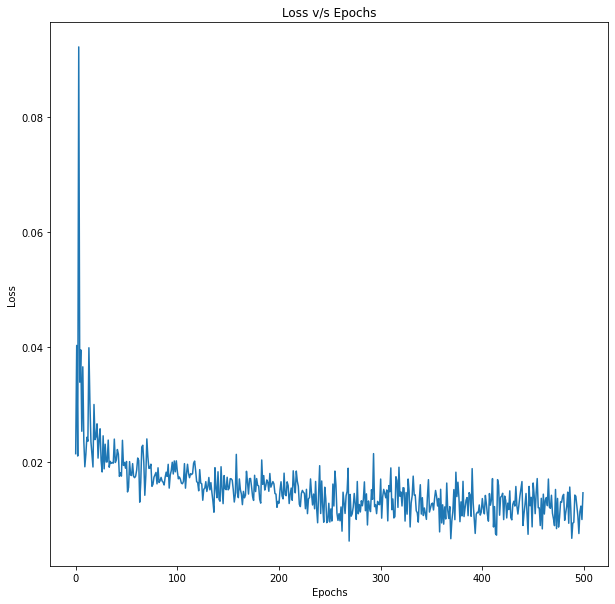

In [10]:
loss_list_dumb = train(model, ds_train_data, ds_test_data, num_epochs=num_epochs)
loss_list = [loss_item.detach() for loss_item in loss_list_dumb]

fig = plt.figure(figsize=(10,10))
plt.plot(list(range(num_epochs)),loss_list)
plt.title("Loss v/s Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [12]:
eval_loader = DataLoader(ds_test_data, batch_size=1, shuffle=True)
loss , acc = test(model=model, test_loader=eval_loader, loss_fn=loss_fn)
print(f'Test Accuracy: {loss:.2f} \n'
      f'Test Loss: {acc: .2f}')

Test Accuracy: 0.51 
Test Loss:  0.73
Test Accuracy: 0.51 
Test Loss:  0.73


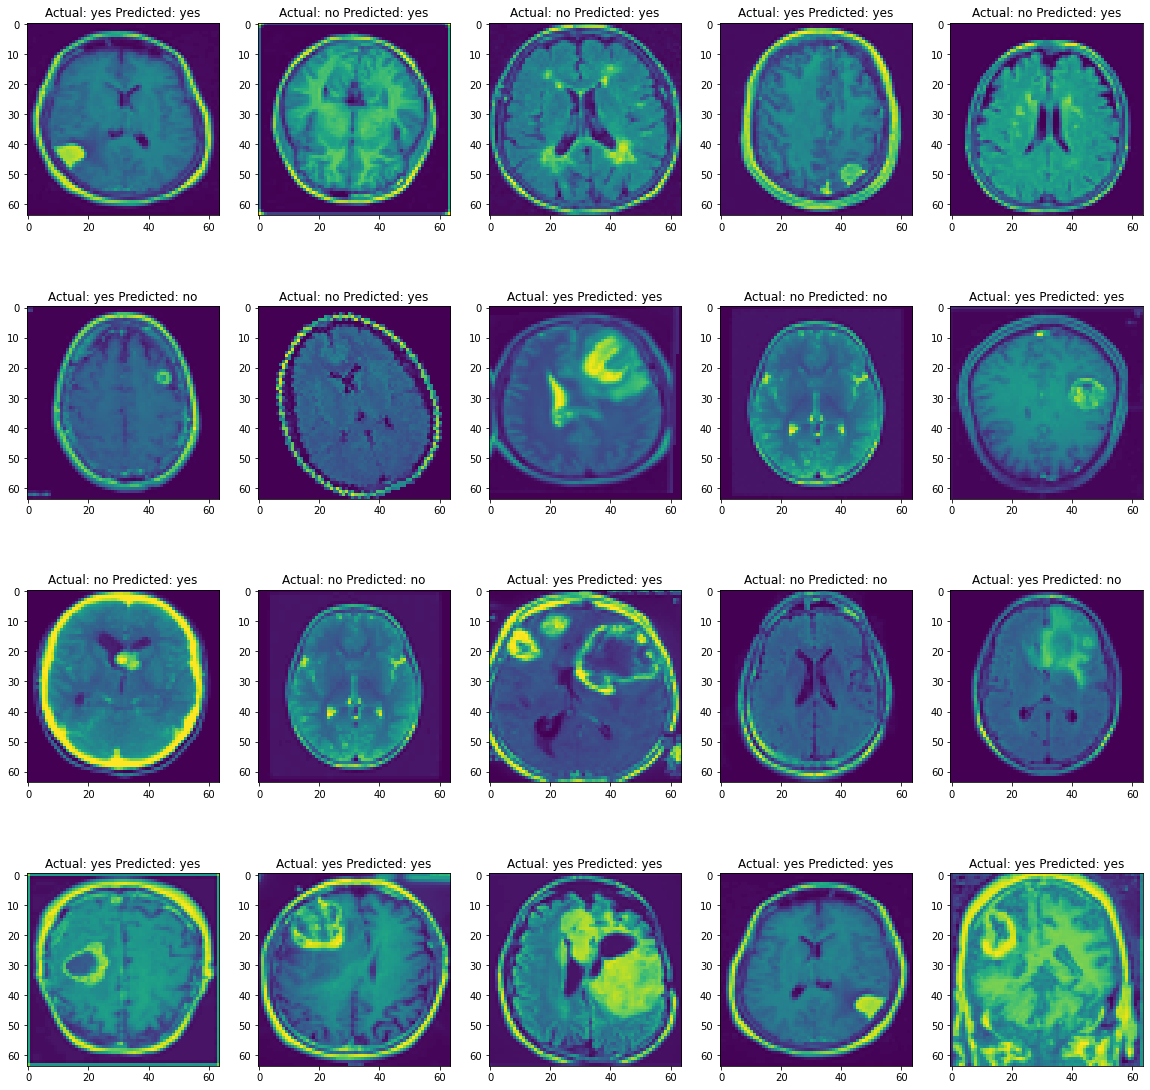

actual accuracy:  0.65


In [10]:
plot_loader = DataLoader(ds_test_data, batch_size=1)

mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
i = 0
correct = 0
raw_predictions = []
for img, lbl in plot_loader:
    if i == 20: break
    pred = model(img.float())
    pred = torch.argmax(pred,dim=1)
    raw_predictions.append(pred)
    plt.subplot(4,5,i+1)
    plt.imshow(img[0][0].cpu())
    if lbl == pred: correct += 1
    plt.title(f'Actual: {mapping[lbl.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
    i+=1
plt.show()
print(f"actual accuracy: {correct/i: .2f}")

## SMPC part

In [4]:
duet_ds = sy.launch_duet(loopback=True)

🎤  🎸  ♪♪♪ Starting Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > STEP 1: Send the following code to your Duet Partner!

import syft as sy
duet = sy.join_duet(loopback=True)

♫♫♫ > Connecting...

♫♫♫ > CONNECTED!



In [5]:
duet_do = sy.join_duet(loopback=True)

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-218-7-180.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


In [6]:
duet_do.store.pandas

""


In [7]:
from sympc.session import Session
from sympc.session import SessionManager

from sympc.tensor import MPCTensor

In [8]:
session = Session(parties=[duet_ds, duet_do])

# print session config
print(f"Session: {session} \n"
      f"Session parties: {session.parties} \n"
      f"Session protocol: {session.protocol} \n"
      f"ring_size: {session.ring_size} \n")


Session: <sympc.session.session.Session object at 0x00000197CE34E340> 
Session parties: [<DomainClient: <UID: 0b1b7eb3607544119c253aa1bc334bd1>>, <Duet: <UID: cf71ac8747c04c20971f64d020d49aaf>>] 
Session protocol: <sympc.protocol.fss.fss.FSS object at 0x00000197CF1FEF10> 
ring_size: 18446744073709551616 



In [14]:
session.protocol

In [9]:
SessionManager.setup_mpc(session)
mpc_model = model.share(session)
mpc_model

In [10]:
x_secret = duet_do.store["#test_tensor_0"]


In [11]:
duet_do.store.pandas

,ID,Tags,Description,object_type
0,<UID: a94208f8d8ae4184a983079f261504e7>,[#test_tensor_0],,<class 'torch.Tensor'>


In [12]:
x = MPCTensor(secret=x_secret, session=session, shape=(1,1,64,64), requires_grad=True)

In [13]:
x

[MPCTensor]
Shape: (1, 1, 64, 64)
Requires Grad: True
	| <DomainClient: <UID: 0b1b7eb3607544119c253aa1bc334bd1>> -> ReplicatedSharedTensorShareTensorUnionPointer
	| <Duet: <UID: cf71ac8747c04c20971f64d020d49aaf>> -> AnyPointer

In [14]:
import time
start_time = time.time()

results = []

encrypted_result = mpc_model(x)
# for ptr in ptrs:
#     encrypted_results = mpc_model(ptr)
#     print(f"encrypted results: {encrypted_results}")
#     plaintext_results = encrypted_results.reconstruct()
#     print(f"plain text results: {plaintext_results}")
#     results.append(plaintext_results)

end_time = time.time()

[2022-03-13T15:23:48.600310+0100][CRITICAL][logger]][10572] UnknownPrivateException has been triggered.


UnknownPrivateException: UnknownPrivateException has been triggered.

In [16]:
x

[MPCTensor]
Shape: torch.Size([1, 1, 64, 64])
Requires Grad: True
	| <DomainClient: <UID: 50d7f2c5f0044e97bacfa432f3644429>> -> ReplicatedSharedTensorShareTensorUnionPointer
	| <Duet: <UID: 082c27dd26394980baaa487319f1bf70>> -> AnyPointer

In [18]:
ds_test_data[0][0].shape

torch.Size([1, 64, 64])

In [19]:
print(f"X @ X = \n {(x @ ds_test_data[0][0]).reconstruct()}")

TypeError: unsupported operand type(s) for @: 'AnyPointer' and 'Tensor'

In [39]:
duet_do

<Duet: <UID: 99d6db0f0b8041fc810966523fdc3daa>>